In [40]:
import pyparetomixture.fit as pm
import pyparetomixture.type as pmt # types
import numpy as np
from pprint import pprint
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate gradient and hessian of parameters on sample

In [16]:
sample = pmt.Sample(np.array([1.5, 2., 3., 5., 5., 8., 11., 11., 11.]))
params = pmt.ParetoMixtureParameters(2., 2., 0.8)

In [17]:
pprint(sample)
pprint(params)

Sample(data=array([ 1.5,  2. ,  3. ,  5. ,  5. ,  8. , 11. , 11. , 11. ]))
ParetoMixtureParameters(alpha=2.0, beta=2.0, p=0.8)


In [18]:
pprint(pm.gradient(params, sample))

Gradient(dll_dalpha=-10.29044630606637,
         dll_dbeta=-0.2161789972280644,
         dll_dp=8.719536405324918)


In [11]:
pprint(pm.hessian(params, sample))

Hessian(dll_dalpha2=-2.1518472965995863,
        dll_dbeta2=0.18711138904116692,
        dll_dp2=-9.652491254931022,
        dll_dalphadbeta=0.025183763003124488,
        dll_dalphadp=0.5559698890040211,
        dll_dbetadp=1.2622099737468828)


# Fit parameters

In [19]:
# pareto mixture parameters, history of iterations during Newton's method
pmp, hist = pm.fit_pareto_mixture_parameters(sample, len(sample.data))

In [26]:
pmp

ParetoMixtureParameters(alpha=0.6010186240737254, beta=-0.0808585579806779, p=0.9999902625563796)

In [27]:
# Observe the gradient is close to zero
pprint(pm.gradient(pmp, sample))

Gradient(dll_dalpha=0.28537221785945344,
         dll_dbeta=2.1609760602168924e-05,
         dll_dp=0.09711422868295223)


In [28]:
pprint(pm.hessian(pmp, sample))

Hessian(dll_dalpha2=-24.915404951686135,
        dll_dbeta2=-0.00027158079446435194,
        dll_dp2=-0.029938687060947673,
        dll_dalphadbeta=-0.00031481767525016525,
        dll_dalphadp=-2.302671224985355,
        dll_dbetadp=-2.2192473163979805)


In [38]:
# Calculate 200 samples of size 10^6, take peak over threshold with k = 200, store fitted parameters in vals
vals = []
for _ in trange(200):
    try:
        sample = np.random.normal(size = 1_000_000)
        sample.sort()
        pot = sample[-200:] / sample[-200]
        pmp, hist = pm.fit_pareto_mixture_parameters(np.array(list(pot)))
        vals.append(pmp) #TODO: how to clone nparrays
    except Exception as e:
        print(e)
        print(pot)


100%|██████████| 200/200 [00:19<00:00, 10.14it/s]


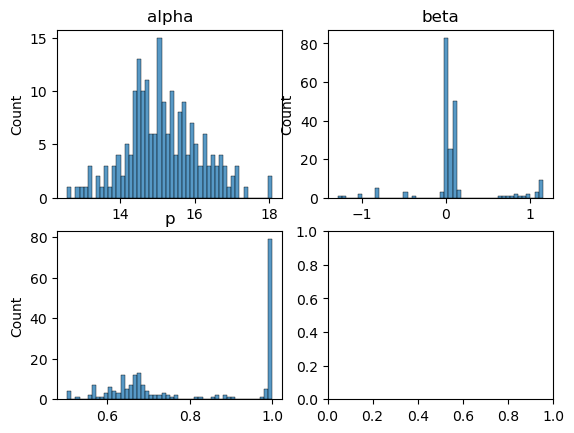

In [43]:

def describe_stats(vals: list[pm.ParetoMixtureParameters]):
    """
    Plot histograms of alpha, beta and p
    """
    alphas = [x.alpha for x in vals]
    betas = [x.beta for x in vals]
    ps = [x.p for x in vals]

    fig, axs = plt.subplots(2, 2)
    sns.histplot(alphas, ax = axs[0,0], bins = 50)
    axs[0,0].set_title("alpha")
    sns.histplot(betas, ax = axs[0,1], bins = 50)
    axs[0,1].set_title("beta")
    sns.histplot(ps, ax = axs[1,0], bins = 50)
    axs[1,0].set_title("p")
    plt.show()

describe_stats(vals)

Observe we have a lot of fitted parameters with $p=1$.

Our hypothesis is that this is a saddle point. We take a single sample with fitted parameters $p=1$.

# Saddle point

In [47]:
sample = pmt.Sample(np.array([1.5, 2., 3., 5., 5., 8., 11., 11., 11.]))
pmp, hist = pm.fit_pareto_mixture_parameters(sample, len(sample.data))
pprint(pmp)

ParetoMixtureParameters(alpha=0.6010186240737254,
                        beta=-0.0808585579806779,
                        p=0.9999902625563796)


In [51]:
hess = pm.hessian(pmp, sample)
hess = np.array(
    [
        [hess.dll_dalpha2, hess.dll_dalphadbeta, hess.dll_dalphadp],
        [hess.dll_dalphadbeta, hess.dll_dbeta2, hess.dll_dbetadp],  
        [hess.dll_dalphadp, hess.dll_dbetadp, hess.dll_dp2],
    ]
)
hess

array([[-2.49154050e+01, -3.14817675e-04, -2.30267122e+00],
       [-3.14817675e-04, -2.71580794e-04, -2.21924732e+00],
       [-2.30267122e+00, -2.21924732e+00, -2.99386871e-02]])

In [52]:
np.linalg.eig(hess)

(array([-25.12833317,  -2.12033566,   2.30305362]),
 array([[-0.99571894, -0.06961954, -0.06080218],
        [-0.00814414,  0.72132079, -0.69255324],
        [-0.09207311,  0.6890932 ,  0.71879977]]))

Observe we have positive and negative eigenvalues at our fitted pareto mixture parameter coordinate. This implies that this matrix is not positive semidefinite. This is a saddle point.

# Frechet
Down here are some experiments with the Frechet distribution

In [421]:
def create_frechet_dist_sample(size, scale):
    exp_vals = np.random.exponential(scale = scale, size = size)
    frechet_vals = 1 / exp_vals

    return np.sort(frechet_vals)

def pot_sample(sample, k):
    values_to_retain = sample[-k:]
    threshold = np.min(values_to_retain)
    return values_to_retain / threshold

TRUE_SCALE = 1
SIZE = 10000
sample = create_frechet_dist_sample(SIZE, TRUE_SCALE)
sample = pot_sample(sample, 2000)

In [422]:
params, hist = pm.fit_pareto_mixture_parameters(sample, 2000)
hist["grad_norm"] = hist["grad"].apply(lambda x: x.norm())
params

ParetoMixtureParameters(alpha=0.9778480984779534, beta=2.479189058949144, p=1.0735780652769615)

<AxesSubplot: ylabel='ll'>

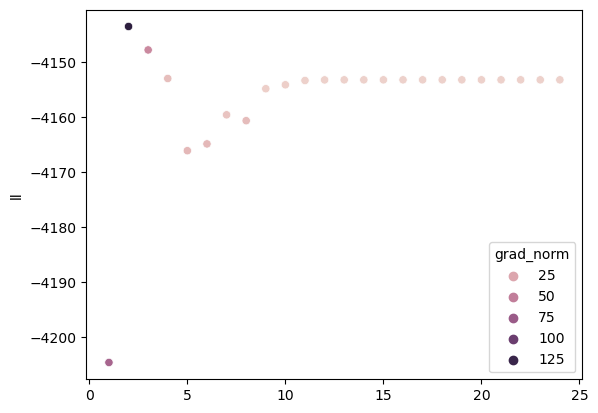

In [423]:
import seaborn as sns
sns.scatterplot(data = hist, x = hist.index, y = "ll", hue = "grad_norm")

In [425]:
hist.sort_values(by = "ll")["params"].iloc[-1]

ParetoMixtureParameters(alpha=0.9778480984779534, beta=2.479189058949144, p=1.0735780652769615)

In [414]:
pm.gradient(params, sample)

Gradient(dll_dalpha=-8.195399914256996e-08, dll_dbeta=-1.1110742344557746e-09, dll_dp=0.02543184057942227)

In [435]:
hist["hess"].apply(lambda x: x.eigenvalues())

1     [-2704.062111744388, -154.79508570408723, -2.6...
2     [-3904.5552443261536, -541.4868070550053, 17.2...
3     [-3310.640004488155, -368.82282368680774, 6.37...
4     [-3040.9106649383634, -254.69849341565882, 1.7...
5     [-2719.313384339392, -118.15595562365374, -3.0...
6     [-2882.664418344745, -191.52291802858534, -2.2...
7     [-3098.543083566202, -297.92690648733225, -1.0...
8     [-3395.731063421189, -467.6233400692597, -0.83...
9     [-3637.2557090801088, -582.075014726671, -0.40...
10    [-3836.316946484586, -680.6109676460029, -0.34...
11    [-3899.645967589678, -708.0205304654849, -0.29...
12    [-3913.4887748314477, -714.1232170053427, -0.2...
13    [-3915.1409174851533, -714.8494281982482, -0.2...
14    [-3915.3098655994995, -714.9236632842135, -0.2...
15    [-3915.326799361181, -714.931103626902, -0.284...
16    [-3915.328493128525, -714.931847830232, -0.284...
17    [-3915.3286625092296, -714.9319222522829, -0.2...
18    [-3915.328679447307, -714.9319296944898, -